# Linear first order differential equation

In this toy example, we consider a first order linear differential equation, $\forall t\in[0, T]$, $a\in\mathbb{R}$,

$$
 \frac{d x(t)}{dt} = a x(t)
$$

with initial condition $x(t_0) = x_0$ true solution $x^\star(t) = x_0 e^{a(t -t_0)} $. It is frequent to work with the logarithmic form of the ODE for stability,

$$
\frac{d u(t)}{dt}=a,
$$
where $u(t)=\log x(t), \forall t.$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Import our package

In [2]:
import jinns

Import other dependencies

In [3]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx

import matplotlib.pyplot as plt

figsize = (4, 4)
plt.rcParams["figure.figsize"] = figsize

key = random.PRNGKey(2)
key, subkey = random.split(key)

In [20]:
# Find out which device (GPU vs CPU) JAX is currently using for computations.
# For GPU, you need to install JAX+GPU prior to jinns
# see https://docs.jax.dev/en/latest/installation.html
jax.devices()

[CpuDevice(id=0)]

Create the neural network architecture for the PINN with `equinox`.

In [4]:
eqx_list = (
    (eqx.nn.Linear, 1, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 1),
    # (jnp.exp,)
)
key, subkey = random.split(key)
u, init_nn_params = jinns.nn.PINN_MLP.create(
    key=subkey, eqx_list=eqx_list, eq_type="ODE"
)

Create a DataGenerator object

In [5]:
nt = 320
batch_size = 32
method = "uniform"
tmin = 0
tmax = 1

Tmax = 3
key, subkey = random.split(key)
train_data = jinns.data.DataGeneratorODE(
    key=subkey,
    nt=nt,
    tmin=tmin,
    tmax=tmax,
    temporal_batch_size=batch_size,
    method=method,
)

### Model parameters




In [6]:
# initial conditions and growth
t0 = 0
x0 = 1.0
a = 1.0

In [7]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={"a": a},
)

Visualize the output of the neural networks before the parameter learning step

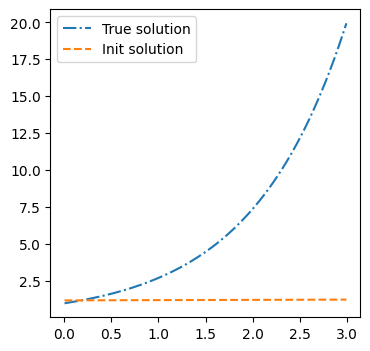

In [8]:
vectorized_u_init = vmap(lambda t: u(t, init_params), (0), 0)


def x_true(t_rescaled):
    # t_rescaled: input in [0, 1]
    return x0 * jnp.exp(a * (t_rescaled * Tmax - t0))


ts = train_data.times.sort(axis=0)
plt.plot(ts * Tmax, vmap(x_true, 0)(ts), "-.", label="True solution")
plt.plot(ts * Tmax, jnp.exp(vectorized_u_init(ts)), "--", label="Init solution")
plt.legend()

## Loss construction

In [9]:
from jinns.loss import ODE


class LinearFODE(ODE):
    def equation(self, t, u, params):
        # in log-space
        u_ = lambda t, p: u(t, p)[0]
        du_dt = jax.grad(u_, 0)(t, params)
        return du_dt - self.Tmax * params.eq_params.a


fo_loss = LinearFODE(Tmax=Tmax)

In [10]:
loss_weights = jinns.loss.LossWeightsODE(dyn_loss=1.0, initial_condition=1.0)

loss = jinns.loss.LossODE(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=fo_loss,
    initial_condition=(float(tmin), jnp.log(x0)),
    params=init_params,
)

In [11]:
# Testing the loss function
train_data, batch = train_data.get_batch()

losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
losses, grads = losses_and_grad(init_params, batch)
l_tot, d = losses
print(f"total loss: {l_tot}")
print(f"Individual losses: { {key: f'{val}' for key, val in d.items()} }")

total loss: 8.771081924438477
Individual losses: {'dyn_loss': '8.74', 'initial_condition': '0.03'}


## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [12]:
params = init_params

In [13]:
# Optimizer
import optax

tx = optax.adam(learning_rate=1e-4)

In [14]:
n_iter = int(10000)

In [15]:
key, subkey = random.split(key)

In [16]:
params, total_loss_list, loss_by_term_dict, data, loss, _, _, _, _, _, _, _ = (
    jinns.solve(
        init_params=params, data=train_data, optimizer=tx, loss=loss, n_iter=n_iter
    )
)

Initialization time: 0.3265063762664795

Compilation took
 0.5288047790527344 

[train] Iteration 0: loss value = 8.768765449523926
[train] Iteration 1000: loss value = 0.24758727848529816
[train] Iteration 2000: loss value = 0.04244536906480789
[train] Iteration 3000: loss value = 0.01112863514572382
[train] Iteration 4000: loss value = 0.0007338324212469161
[train] Iteration 5000: loss value = 0.00043840333819389343
[train] Iteration 6000: loss value = 0.0005523202707991004
[train] Iteration 7000: loss value = 0.0004192023479845375
[train] Iteration 8000: loss value = 5.523091022041626e-05
[train] Iteration 9000: loss value = 8.352274016942829e-05

Stopping main optimization loop, cause: max iteration is reached

Training took
 0.46056628227233887 


Final iteration 10000: train loss value = 2.8334821763564833e-05


## Results

Plot the loss values

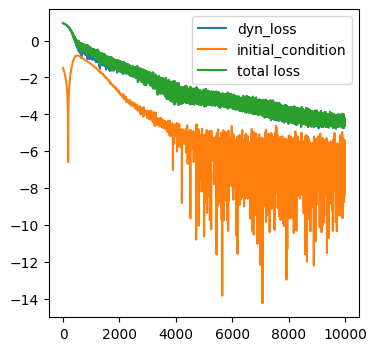

In [17]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show()

Plot the ODE solutions learned by the PINN

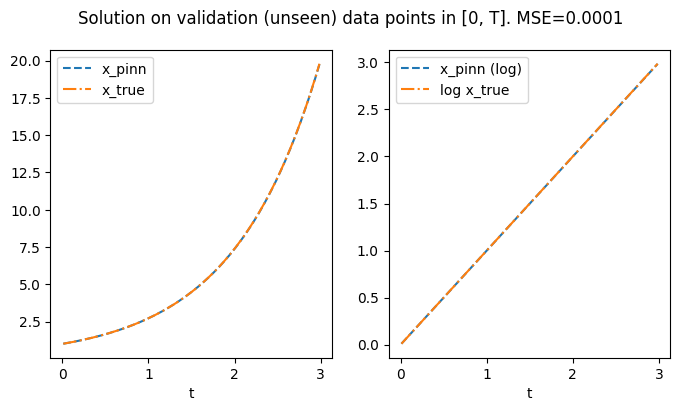

In [18]:
import pandas as pd

u_est = vmap(lambda t: u(t, params), (0), 0)


key, subkey = random.split(key, 2)
val_data = jinns.data.DataGeneratorODE(
    key=subkey, nt=nt, tmin=tmin, tmax=tmax, method=method, temporal_batch_size=None
)

ts = val_data.times.sort(axis=0).squeeze()  # in [0, 1]
df = pd.DataFrame(
    {
        "t": ts * Tmax,  # rescale time for plotting
        "x_pinn": jnp.exp(u_est(ts).squeeze()),
        "x_true": vmap(x_true)(ts),
        "x_pinn (log)": u_est(ts).squeeze(),
        "log x_true": jnp.log(x0) + a * (ts * Tmax - t0),
    },
)

mse = jnp.mean((jnp.exp(u_est(ts).squeeze()) - vmap(x_true)(ts)) ** 2)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
df.plot(
    x="t",
    y=["x_pinn", "x_true"],
    style=["--", "-."],
    ax=axes[0],
)
df.plot(
    x="t",
    y=["x_pinn (log)", "log x_true"],
    style=["--", "-."],
    ax=axes[1],
)
fig.suptitle(f"Solution on validation (unseen) data points in [0, T]. MSE={mse:.4f}")
plt.show()

The found solution agrees perfectly on unseen data point. This is expected in this very simple toy example where the neural net must learn a linear function of t (in log-space). 

Finally, in more involved settings, it can be of interest to display the equation's residuals (on training points) to see if there is some locations where the equation is hard to learn. This is easily doable in jinns using `loss.equation()` method as below. In this simple example, we don't see any particuliar time pattern, the residuals seem to be indepently distributed.


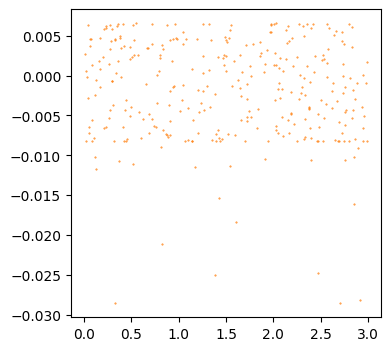

In [19]:
plt.scatter(
    ts * Tmax,
    jax.vmap(fo_loss.equation, (0, None, None))(train_data.times, u, params),
    color="tab:orange",
    s=0.2,
)